https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html

Acceleration of the kernel herding algorithm by improved gradient approximation

https://github.com/satoshi-hayakawa/kernel-quadrature

https://eclass.uoa.gr/modules/document/file.php/MATH305/%CE%92%CE%BF%CE%B7%CE%B8%CE%B7%CF%84%CE%B9%CE%BA%CF%8C%20%CF%85%CE%BB%CE%B9%CE%BA%CF%8C/SynolaBorel.pdf

https://members.cbio.mines-paristech.fr/~jvert/svn/kernelcourse/slides/master2017/master2017.pdf

https://github.com/PCAubin/RKHS/blob/master/IntroductionRKHS-121018.ipynb

https://tutorial.math.lamar.edu/classes/calciii/DoubleIntegrals.aspx

https://www.gatsby.ucl.ac.uk/~gretton/coursefiles/lecture4_introToRKHS.pdf

https://d3bxy9euw4e147.cloudfront.net/oscms-prod/media/documents/CalculusVolume1-OP.pdf

In [16]:
# !pip install gurobipy

In [17]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import functools
import time

# global
lam = 1
num = 0
data = 0
data_test = 0
data_t_out = 0
k_exp_ = 0
k_exp_exp_ = 0


def gen_params(n):
    return np.random.randint(num, size=n)


def preprocess(data_name):
    # read data
    global data, data_test, data_t_out
    data_read = np.loadtxt('3D_spatial_network.txt', delimiter=',', usecols=(1, 2, 3))
    np.random.shuffle(data_read)
    global num
    num, dim = data_read.shape
    if data_name == '3Dnet':
        num = num // 10
    num = 123
    data = data_read[:num, :]
    for i in range(dim):
        data[:, i] = (data[:, i] - np.mean(data[:, i])) / np.std(data[:, i])
    data_test = data[:, dim-1:dim].reshape((num,))
    data_t_out = data_test * (data[:, 0:1] >= 0).reshape((num,))
    data_t_out = data_t_out * (data[:, 1:2] >= 0).reshape((num,))
    global lam
    lam = median_heuristics()
    k_exp_comp()
    k_exp_exp_comp()


def k(x, y=0, diag=False, data_k=None, lam_k=None, kernel=None):
    # x, y: array of indices
    if lam_k is None:
        lam_k = lam
    if data_k is None:
        data_k = data
    if np.isscalar(x):
        x = np.array([x])
    if diag:
        return np.ones(len(x))
    if np.isscalar(y):
        y = np.array([y])
    K = euclidean_distances(data_k[x, :], data_k[y, :], squared=True)
    if kernel is None:
        kernel = 'Gaussian'
    if kernel == 'Gaussian':
        return np.exp(- K / (2 * lam))  # Gaussian
    else:
        return 1 / (1 + K / (2 * lam))  # rational quadratic

def kernel_K(x, y=0, diag=False, data_k=None, lam_k=None, kernel=None):

    K = euclidean_distances(x, y, squared=True)
    if kernel is None:
        kernel = 'Gaussian'
    if kernel == 'Gaussian':
        return np.exp(- K / (2 * lam))  # Gaussian
    else:
        return 1 / (1 + K / (2 * lam))  # rational quadratic


def herding(m, reweight=False):
    ip = np.zeros(num)
    xal = np.arange(num)
    xnew = np.random.randint(num, size=1)
    x = [xnew]
    for i in range(m - 1):
        ip = ip + k(xal, xnew).reshape((num,)) - k_exp(xal)
        # print("ip {}".format(ip))
        xnew = np.argmin(ip)
        x = np.append(x, xnew)
        # print("x {}".format(xnew))
    x = x.astype(int)
    # print("x herding {}".format(x))
    if reweight:
        return x, grlp.QP(k(x, x), k_exp(x), k_exp_exp(), nonnegative=True)
    else:
        return x, np.ones(m) / m

def func(name, n, rec=0, nys=0):
    x = []
    w = []
    idx = []
    fails = 0
    # x, w = herding(n)
    x, w = BPCG(n)
    return x, w, fails


def k_exp_exp():
    return k_exp_exp_


def k_exp_exp_comp():  # post computation
    global k_exp_exp_
    k_exp_exp_ = np.sum(k_exp_) / num


def k_exp(x):
    return k_exp_[x]


def k_exp_comp():  # post computation
    r = np.ones((num,))
    r /= num
    xal = np.arange(num)
    xsp = np.array_split(xal, np.minimum(50, len(xal)))
    dots = [k(x, xal) @ r for x in xsp]
    global k_exp_
    k_exp_ = np.concatenate(dots)


def median_heuristics():
    num_mh = np.minimum(10000, num)
    xal = np.arange(num_mh)
    xsp = np.array_split(xal, np.minimum(50, len(xal)))
    tmp = np.zeros(num_mh)
    for x in xsp:
        tmp = np.append(tmp, euclidean_distances(
            data[x, :], data[xal, :], squared=True).reshape(num_mh * len(x)))
    return np.median(tmp) / 2


def eval(x, w, pr=False):
    if pr == True:
        print(w)
    if len(x) == 0:
        return 10000000000
    m = len(x)
    tmp = np.transpose(w) @ k_exp(x)
    ret = (k_exp_exp() - tmp) + (np.transpose(w) @ k(x, x) @ w - tmp)
    return ret

In [18]:
import gurobipy as gp


def LP(K, B, set_objective=False, obj=[]):
    m, n = K.shape
    model = gp.Model("test")
    x = model.addMVar(n)
    model.update()
    for i in range(m):
        model.addConstr(K[i, :] @ x == B[i])
    print("done")
    model.addConstr(x >= 0)
    if(set_objective == True):
        model.setObjective(obj @ x)
    else:
        model.setObjective(0)
    model.optimize()
    sol = []
    if model.Status == gp.GRB.OPTIMAL:
        for i in range(n):
            if x[i].X > 0:
                sol += [(i, x[i].X)]
    else:
        print("FAILED")
    return sol


def QP(A, EA, EE=0, nonnegative=False):
    m = len(EA)
    model = gp.Model("test")
    w = model.addMVar(m)
    model.update()
    if nonnegative == True:
        model.addConstr(w >= 0)
    model.setObjective(w @ A @ w - 2 * EA @ w + EE)
    model.optimize()
    wei = []
    if model.Status == gp.GRB.OPTIMAL:
        for i in range(m):
            wei += [w[i].X]
    else:
        print("FAILED")
    return wei


In [19]:

def mc_bayes(m, nn=False):
    pt = gen_params(m)
    return pt, QP(k(pt, pt), k_exp(pt), k_exp_exp(), nonnegative=nn)

In [20]:
def experiments(
    data_name='3Dnet',
    kernel='Gaussian',
    times=50,
    np_seed=None
):
    np.random.seed(np_seed)
    preprocess(data_name)
    # return
    # enys.k = functools.partial(k, data_k=data, lam_k=lam, kernel=kernel)

    text_data = open("{}_{}_t{}.txt".format(
        data_name, kernel, times), 'w', encoding='utf-8')
    print("np_seed = {}".format(np_seed), file=text_data)

    fig = plt.figure()
    # x_ex = [5, 10, 20, 40, 60, 80, 120, 160]
    x_ex = [5]
    # m_names = ['N. + emp + opt', 'Nyström', 'Nyström + opt',
    #            'FNE', 'FNE + opt', 'iid Bayes']
    m_names = ['iid Bayes']
    methods = len(m_names)
    results = [[] for i in range(methods)]
    results_up = [[] for i in range(methods)]
    results_low = [[] for i in range(methods)]
    m_marks = ['x', 'o', '^', 'v', '+', '>', '<', 'd', 's']
    for n in x_ex:
        print("{} points. ".format(n), file=text_data)
        for i in range(methods):
            start_time = time.perf_counter()
            res = np.zeros(times)
            fails = 0
            for j in range(times):
                N = n*n
                if 'Mercer' in m_names[i] or 'Nyström' in m_names[i]:
                    N = 20*n
                points, weights, tmp_fails = func(
                    m_names[i], n, rec=N, nys=10*n)
                res[j] = eval(points, weights)
                fails += tmp_fails
            end_time = time.perf_counter()
            elapsed = (end_time - start_time)/times
            res_sq = np.std(res)
            res_mn = np.mean(res)
            res = np.log10(res)
            log_res = np.mean(res)
            log_std = np.std(res)
            results[i].append(np.mean(res))
            results_up[i].append(log_res + log_std)
            results_low[i].append(log_res - log_std)
            print("    {}: {:.2e} (±{:.2e}), {:.2e}s, {} fails".format(
                m_names[i], res_mn, res_sq, elapsed, fails), file=text_data)
    x = np.log10(x_ex)

    for i in range(methods):
        plt.plot(x, results[i], label=m_names[i], marker=m_marks[i])
        plt.fill_between(x, results_low[i], results_up[i], alpha=0.3)
    # plt.xscale("log", nonposx='clip')
    # plt.yscale("log", nonposy='clip')
    plt.legend(loc='lower left', fontsize=12)
    plt.xlabel("$\mathrm{log}_{10} n$", fontsize=20)
    plt.ylabel("$\mathrm{log}_{10} (\mathrm{wce})^2$", fontsize=20)
    plt.tight_layout()
    plt.show()
    fig.savefig("{}_{}_t{}.pdf".format(data_name, kernel, times))
    text_data.close()

<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
/var/folders/st/_m1f9dzd68nfs3y_cznwhv080000gn/T/ipykernel_40347/148460011.py:61: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mathrm{log}_{10} n$", fontsize=20)
/var/folders/st/_m1f9dzd68nfs3y_cznwhv080000gn/T/ipykernel_40347/148460011.py:62: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathrm{log}_{10} (\mathrm{wce})^2$", fontsize=20)


In [21]:
def grad_F(xi):
    r = np.ones((num, 1)) 
    r /= num
    r = xi - r
    xal = np.arange(num)
    xsp = np.array_split(xal, np.minimum(50, len(xal)))
    dots = [k(x, xal) @ r for x in xsp]
    k_tmp = np.concatenate(dots)
    return np.sqrt(k_tmp)

In [22]:
def F_func(xi):
    r = np.ones((num, 1)) 
    r /= num
    r = xi  - r
    xal = np.arange(num)
    xsp = np.array_split(xal, np.minimum(50, len(xal)))
    dots = [k(x, xal) @ r for x in xsp]
    k_tmp = np.concatenate(dots)
    return (k_tmp.T @ r)[0, 0]

In [23]:
def _inner_(x1, x2):
    K = euclidean_distances(x1, x2, squared=True)
    return np.exp(- K / (2 * lam)) 

    # Linearly Convergent Frank-Wolfe with Backtracking Line-Search
def backtracking_ls_alpha(xi, objectiveFunction, step_size_ub, direction, steps):
    step_size = step_size_ub
    direction = 1
    print("direction d {}".format(direction))
    i = 0
    ls_eps = 0.1
    evalu_oldpint = objectiveFunction(xi)
    evalu_newpoint = objectiveFunction(xi - step_size * direction)
    while (evalu_newpoint - evalu_oldpint) > ls_eps * step_size * direction:
        if i > steps:
            if evalu_oldpint - evalu_newpoint >= ls_eps:
                return step_size
            else:
                return 0
        step_size *= ls_eps
        evalu_newpoint = objectiveFunction(xi - step_size * direction)
        i += 1
    assert (evalu_oldpint - evalu_newpoint >= 0)
    return step_size

def id_in_list(X, value):
    for i in range(len(X)):
        if X[i] == value:
            return i
    return False

def FW_step(grad):
    if grad.ndim == 2:
        grad_t = np.sum(grad, axis=1) / num
    else:
        grad_t = grad
    min_id = np.argmin(grad_t)
    return min_id

def away_step(grad):
    max_id = np.argmax(grad)
    return max_id

def diract(x):  # post computation
    xal = np.arange(num)
    dots = [k(x, x_1) for x_1 in xal]
    return np.array(np.concatenate(dots))

def _calc_xi(d_list, w):
    xi = np.zeros(shape=(num , 1))
    n_d = len(d_list)
    for i in range(n_d):
        xi += d_list[i] * w[i]
    return xi

def get_d_list(X_list):
    ret = []
    for x in X_list:
        d = diract(x)
        ret.append(d)
    return ret

def inner_over_k(grad, d_list):
    ret = []
    for d in d_list:
        ret.append(kernel_K(grad.T, d.T)[0])
    return np.array(ret)

def kernel_K(x, y=0, diag=False, data_k=None, lam_k=None, kernel=None):
    K = euclidean_distances(x, y, squared=True)
    return np.exp(- K / (2 * lam))  # Gaussian

loss = []

def BPCG(m):

    T = 30
    x_0 = np.random.randint(num, size=1)

    X_all = np.arange(num)
    X_list = [x_0]

    W = np.array([1])

    d_x_al_list = get_d_list(X_all)

    for t in range(T):

        d_x_list = get_d_list(X_list)

        xi_t = _calc_xi(d_x_list, W)

        product_x = inner_over_k(grad_F(xi_t), d_x_list)

        product_x_al = inner_over_k(grad_F(xi_t), d_x_al_list)
        
        x_A = away_step(product_x).astype(np.int64)

        x_S = FW_step(product_x).astype(np.int64)

        x_W = FW_step(product_x_al).astype(np.int64)

        d_A = diract(x_A)
        d_S = diract(x_S)
        d_W = diract(x_W)

        grad_xi = grad_F(xi_t)

        if inner_over_k(grad_xi, [d_A - d_S]) > inner_over_k(grad_xi, [xi_t - d_W]):
            eta = d_A - d_S
            d_A_list = get_d_list([x_A])
            xi_A = _calc_xi(d_A_list, [1])
            a_t = backtracking_ls_alpha(xi_t, F_func, xi_A, grad_xi, 10)

            if a_t > xi_A:
                i_A = id_in_list(X_list, x_A)
                if i_A != False:
                    X_list = X_list.pop(x_A)
                    W = np.delete(W, i_A)
                    print("W {}".format(W))
                    print("len X list {}".format(len(X_list)))
        else:
            print(" step .... 2")
            eta = xi_t - d_W
            a_t = backtracking_ls_alpha(xi_t, F_func, 1, grad_xi, 10)
            X_list = np.append(X_list, x_W)
            W = update_weight(a_t, None, W)
            print("W {}".format(W))
            print("X list {}".format(len(X_list)))

        print("a_t update {}".format(a_t))
        xi_t = xi_t - a_t * eta
        loss.append(F_func(xi_t))

        print("loss: {}".format(F_func(xi_t)))
        
    return X_list, W

def update_weight(step_size, i_w, w):
    w = (1 - step_size) * w  # update weight for all the atoms originally in the s_list
    w = np.append(w, step_size)
    return w


 step .... 2
direction d 1
W [0.9 0.1]
X list 2
a_t update 0.1
loss: 1097.6994902061397
 step .... 2
direction d 1
W [0.81 0.09 0.1 ]
X list 3
a_t update 0.1
loss: 935.8580602554944
 step .... 2
direction d 1
W [0.729 0.081 0.09  0.1  ]
X list 4
a_t update 0.1
loss: 801.9010169022438
 step .... 2
direction d 1
W [0.6561 0.0729 0.081  0.09   0.1   ]
X list 5
a_t update 0.1
loss: 690.8168752022053
 step .... 2
direction d 1
W [0.59049 0.06561 0.0729  0.081   0.09    0.1    ]
X list 6
a_t update 0.1
loss: 598.5176774996597
 step .... 2
direction d 1
W [0.531441 0.059049 0.06561  0.0729   0.081    0.09     0.1     ]
X list 7
a_t update 0.1
loss: 521.6663887276344
 step .... 2
direction d 1
W [0.4782969 0.0531441 0.059049  0.06561   0.0729    0.081     0.09
 0.1      ]
X list 8
a_t update 0.1
loss: 457.536800052627
 step .... 2
direction d 1
W [0.43046721 0.04782969 0.0531441  0.059049   0.06561    0.0729
 0.081      0.09       0.1       ]
X list 9
a_t update 0.1
loss: 403.8997929331708
 st

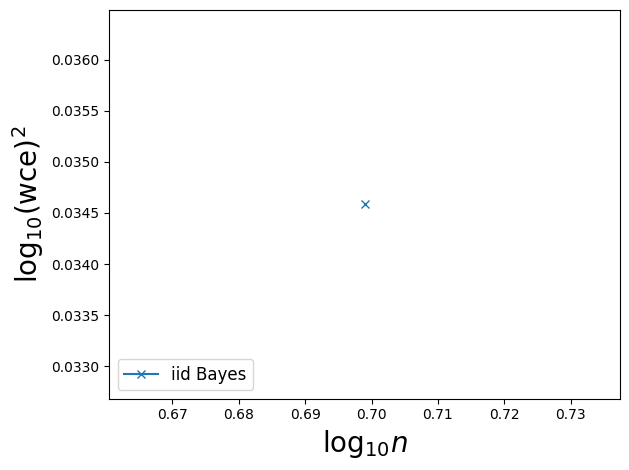

In [24]:
np_seed = 20922295
times = 1
experiments(data_name='3Dnet', times=times, kernel='Gaussian', np_seed=np_seed)

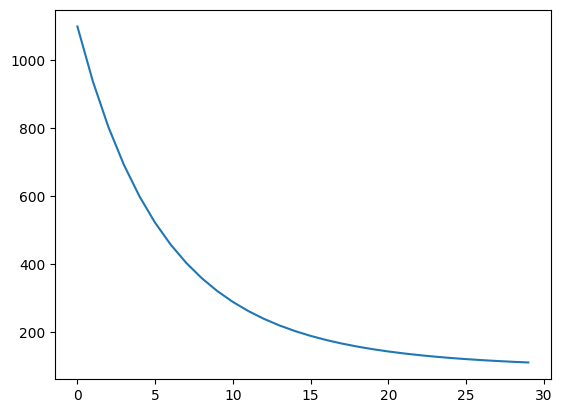

In [25]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(loss))], loss)

In [26]:
plt.show()

In [27]:
def BPCG_lazy(m):

    T = 30
    
    x_0 = np.random.randint(num, size=1)

    X_all = np.arange(num)

    X_list = [x_0]

    W = np.array([1])

    d_x_al_list = get_d_list(X_all)

    for t in range(T):

        d_x_list = get_d_list(X_list)

        xi_t = _calc_xi(d_x_list, W)

        product_x = inner_over_k(grad_F(xi_t), d_x_list)

        product_x_al = inner_over_k(grad_F(xi_t), d_x_al_list)
        
        x_A = away_step(product_x).astype(np.int64)

        x_S = FW_step(product_x).astype(np.int64)

        x_W = FW_step(product_x_al).astype(np.int64)

        d_A = diract(x_A)
        d_S = diract(x_S)
        d_W = diract(x_W)

        grad_xi = grad_F(xi_t)

        if inner_over_k(grad_xi, [d_A - d_S]) > inner_over_k(grad_xi, [xi_t - d_W]):
            eta = d_A - d_S
            d_A_list = get_d_list([x_A])
            xi_A = _calc_xi(d_A_list, [1])
            a_t = backtracking_ls_alpha(xi_t, F_func, xi_A, grad_xi, 10)
            print(" step .... 1")

            if a_t > xi_A:
                i_A = id_in_list(X_list, x_A)
                if i_A != False:
                    X_list = X_list.pop(x_A)
                    W = np.delete(W, i_A)
                    print("W {}".format(W))
                    print("len X list {}".format(len(X_list)))

        else:
            
            print(" step .... 2")
            eta = xi_t - d_W
            a_t = backtracking_ls_alpha(xi_t, F_func, 1, grad_xi, 10)
            X_list = np.append(X_list, x_W)
            W = update_weight(a_t, None, W)
            print("W {}".format(W))
            print("X list {}".format(len(X_list)))

        print("a_t update {}".format(a_t))
        xi_t = xi_t - a_t * eta
        loss.append(F_func(xi_t))

        print("loss: {}".format(F_func(xi_t)))
        
    return X_list, W

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9c7bc7a2-518f-4da2-a8d2-a949e3fc47bb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>